### Model Evaluation

In [2]:
import h5py
import tensorflow as tf
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from keras import backend as K
from sklearn.metrics import classification_report

In [3]:
def focal_loss(alpha=0.14, gamma=2):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, 1e-7, 1 - 1e-7)
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        loss = -alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1) \
               - (1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0)
        return K.mean(loss)
    return focal_loss_fixed

#### Resnet Model

In [4]:
X_test_num = np.load('../data/test/numerical/X_test_scaled.npy')
y_test_num = np.load('../data/test/numerical/y_test.npy')
resnet_model = tf.keras.models.load_model('../model/balanced(best)/resnet_best(epoch34).h5', custom_objects={'focal_loss_fixed': focal_loss()})

In [4]:
resnet_predictions = resnet_model.predict(X_test_num)

105940/105940 [==============================] - 173s 2ms/step


In [ ]:
# save the predictions
np.save('../data/prediction_result/resnet_predictions.npy', resnet_predictions)

In [6]:
# load the predictions
resnet_predictions = np.load('../data/prediction_result/resnet_predictions.npy')

In [7]:
# check the accuracy
accuracy = accuracy_score(y_test_num, resnet_predictions.round())
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 79.75


In [8]:
# check the classification report
print(classification_report(y_test_num, resnet_predictions.round(), digits=4))

              precision    recall  f1-score   support

           0     0.3245    0.6799    0.4394    395685
           1     0.9505    0.8130    0.8764   2994384

    accuracy                         0.7975   3390069
   macro avg     0.6375    0.7464    0.6579   3390069
weighted avg     0.8775    0.7975    0.8254   3390069



#### LSTM

In [9]:
lstm_model = tf.keras.models.load_model('../model/balanced(best)/lstm__strongActions(epoch8).h5', custom_objects={'focal_loss_fixed': focal_loss()})
X_test_seq = np.load('../data/test/timeSeries_StrongAction/X_test.npy')
y_test_seq = np.load('../data/test/timeSeries_StrongAction/y_test.npy')

In [8]:
lstm_predictions = lstm_model.predict(X_test_seq)

65091/65091 [==============================] - 326s 5ms/step


In [9]:
# save predictions
np.save('../data/prediction_result/lstm_predictions.npy', lstm_predictions)

In [10]:
# check accuracy
accuracy = accuracy_score(y_test_seq, np.round(lstm_predictions))
print('Accuracy: ', accuracy)

Accuracy:  0.7718378385385285


In [7]:
lstm_predictions = np.load('../data/prediction_result/lstm_predictions.npy')

In [10]:
# check precision, recall, f1-score
print(classification_report(y_test_seq, np.round(lstm_predictions), digits=4))

              precision    recall  f1-score   support

         0.0     0.2977    0.6708    0.4123    248572
         1.0     0.9463    0.7855    0.8584   1834315

    accuracy                         0.7718   2082887
   macro avg     0.6220    0.7281    0.6354   2082887
weighted avg     0.8689    0.7718    0.8052   2082887



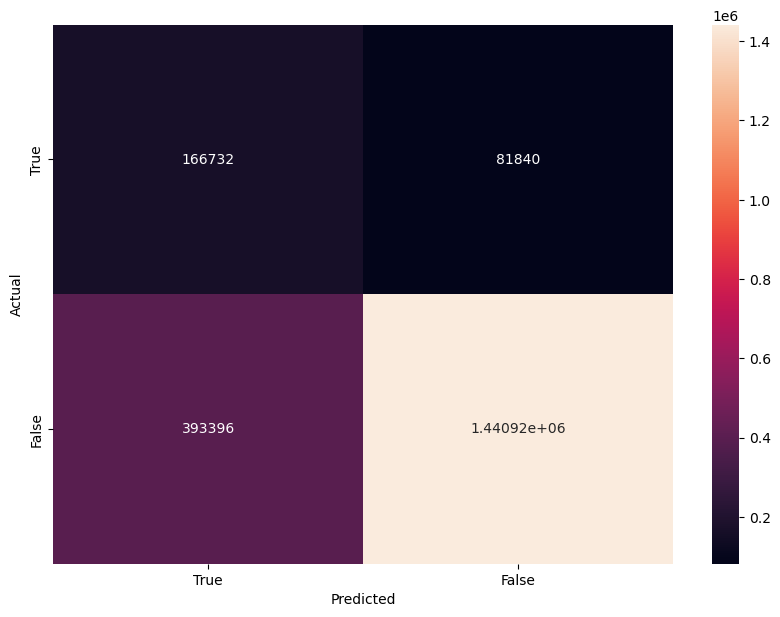

In [13]:
# draw confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

cm = confusion_matrix(y_test_seq, np.round(lstm_predictions))
df_cm = pd.DataFrame(cm, index=['True', 'False'], columns=['True', 'False'])
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


#### NCF

In [4]:
custom_objects = {'focal_loss_fixed': focal_loss()}

ncf_model = tf.keras.models.load_model('../model/balanced(best)/best_ncf_model(epoch77).h5', custom_objects=custom_objects)
X_test_user_ncf = np.load('../data/test/ncf/realworld_10%/X_test_user_encoded.npy')
X_test_item_ncf = np.load('../data/test/ncf/realworld_10%/X_test_item_encoded.npy')
X_test_features_ncf = np.load('../data/test/ncf/realworld_10%/X_test_features.npy')
y_test_ncf = np.load('../data/test/ncf/realworld_10%/y_test.npy')

In [15]:
ncf_predictions = ncf_model.predict([X_test_user_ncf, X_test_item_ncf, X_test_features_ncf])

48748/48748 [==============================] - 46s 938us/step


In [16]:
# save predictions
np.save('../data/prediction_result/ncf_predictions.npy', ncf_predictions)

In [3]:
# load the predictions
ncf_predictions = np.load('../data/prediction_result/ncf_predictions.npy')

In [17]:
# check accuracy
accuracy = accuracy_score(y_test_ncf, np.round(ncf_predictions))
print('Accuracy: ', accuracy)

Accuracy:  0.735262819148527


In [12]:
# check precision, recall, f1-score
print(classification_report(y_test_ncf, np.round(ncf_predictions), digits=4))

              precision    recall  f1-score   support

           0     0.1624    0.2724    0.2035    193667
           1     0.8859    0.8009    0.8412   1366265

    accuracy                         0.7353   1559932
   macro avg     0.5242    0.5366    0.5224   1559932
weighted avg     0.7961    0.7353    0.7621   1559932



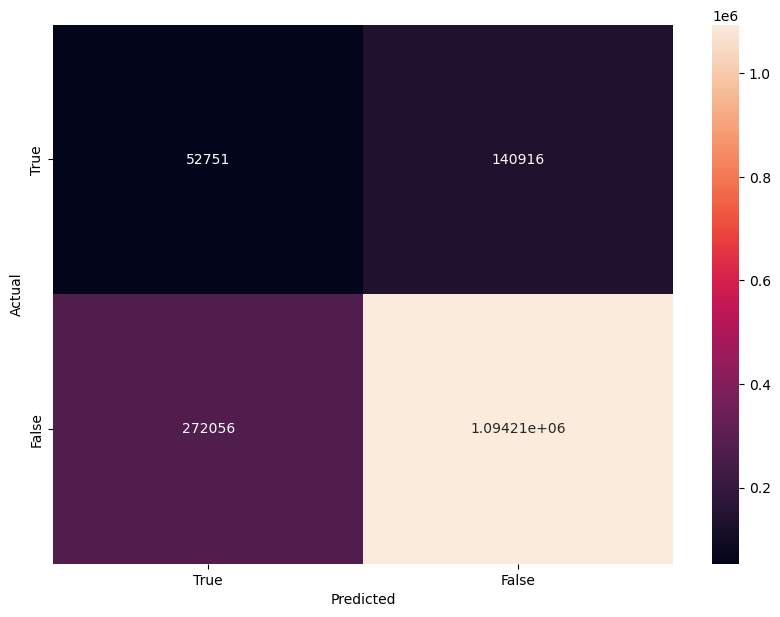

In [19]:
# draw confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

cm = confusion_matrix(y_test_ncf, np.round(ncf_predictions))
df_cm = pd.DataFrame(cm, index=['True', 'False'], columns=['True', 'False'])
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### ROC Curve

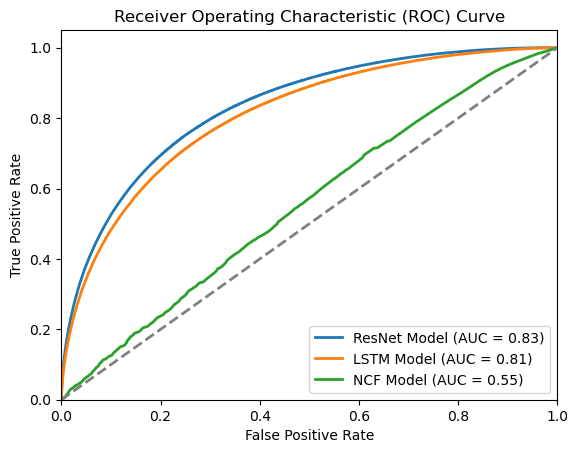

In [20]:
def plot_roc_curve(y_test, predictions, model_name):
    """
    draw the ROC curve
    for single model
    """
    # calculate fpr, tpr
    fpr, tpr, _ = roc_curve(y_test, predictions)
    
    # calculate AUC
    roc_auc = auc(fpr, tpr)
    
    # plot the ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

def plot_all_models_roc(y_test_num, y_test_seq, y_test_ncf, 
                        resnet_predictions, lstm_predictions, ncf_predictions):
    """
    plot the ROC curve for all three models
    
    features:
    y_test_num, y_test_seq, y_test_ncf: test labels for three models
    resnet_predictions, lstm_predictions, ncf_predictions: predictions for three models
    """
    plt.figure()
    
    plot_roc_curve(y_test_num, resnet_predictions, 'ResNet Model')
    plot_roc_curve(y_test_seq, lstm_predictions, 'LSTM Model')
    plot_roc_curve(y_test_ncf, ncf_predictions, 'NCF Model')
    
    plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

plot_all_models_roc(y_test_num, y_test_seq, y_test_ncf, 
                    resnet_predictions, lstm_predictions, ncf_predictions)